<a href="https://colab.research.google.com/github/CristobalSVM/Datos_Masivos/blob/main/Datos_Masivos_mini_proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

El conjunto de datos incluye 42,656 reseñas de 3 sucursales de Disneyland: París, California y Hong Kong, publicadas por visitantes en Trip Advisor.

 \\

Descripción de las columnas:

\\

*   **Review_ID**: identificador único asignado a cada reseña.


*   **Rating**: calificación que va de 1 (insatisfecho) a 5 (satisfecho).


*   **Year_Month**: cuando el revisor visitó el parque temático.



*   **Reviewer_Location**: país de origen del visitante.


*   **Review_Text**: comentarios realizados por el visitante.

*   **Disneyland_Branch**: ubicación del parque Disneyland.

In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import string
import re

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Lectura de datos
# ==============================================================================
import pandas as pd
df = pd.read_excel('/content/DisneylandReviews.xlsx')#,encoding='latin-1')


In [ ]:
df_branch = df['Branch']

In [ ]:
#df_branch = df['Branch']
N=len(df_branch)
n_california = 0
n_paris = 0
n_hk = 0
for i in range(N):
        if df_branch[i] == 'Disneyland_California':
            n_california += 1
        elif df_branch[i] == 'Disneyland_Paris':
            n_paris += 1
        else:
            n_hk +=1

print('Número de comentarios de Disney California: ' + str(n_california))
print('Número de comentarios de Disney Paris: ' + str(n_paris))
print('Número de comentarios de Disney Hong Kong: ' + str(n_hk))

Número de comentarios de Disney California: 19406
Número de comentarios de Disney Paris: 13630
Número de comentarios de Disney Hong Kong: 9620


In [ ]:
# Se seleccionan y renombran las columnas de interés
#df = df[['Review_ID',	'Rating','Year_Month','Reviewer_Location','Review_Text','Branch']]
df.columns = ['ID', 'Rating', 'fecha', 'país_visitante','texto','Disneyland']
df.head()

,ID,Rating,fecha,país_visitante,texto,Disneyland
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [ ]:
# Parseo de fechas
df['fecha'] = pd.to_datetime(df['fecha'])

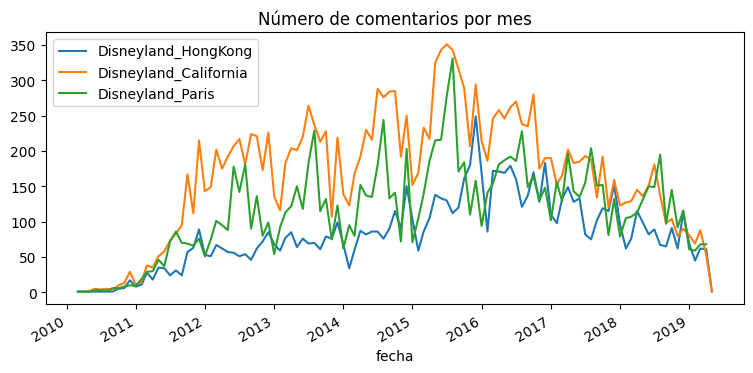

In [ ]:
# Distribución temporal de los comentarios
# ==============================================================================
fig, ax = plt.subplots(figsize=(9,4))

for i in df.Disneyland.unique():
    df_temp = df[df['Disneyland'] == i].copy()
    df_temp['fecha'] = pd.to_datetime(df_temp['fecha'].dt.strftime('%Y-%m'))
    df_temp = df_temp.groupby(df_temp['fecha']).size()
    df_temp.plot(label=i, ax=ax)

ax.set_title('Número de comentarios por mes')
ax.legend()

In [ ]:
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''

    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]

    return(nuevo_texto)

test = "Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining"
print(test)
print(limpiar_tokenizar(texto=test))

Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining
['esto', 'es', 'ejemplo', 'de', 'limpieza', 'de', 'texto', 'cienciadedatos', 'textmining']


In [ ]:
# Se aplica la función de limpieza y tokenización a cada comentario
# ==============================================================================
df['texto_tokenizado'] = df['texto'].apply(lambda x: limpiar_tokenizar(x))
df[['texto', 'texto_tokenizado']].head()

,texto,texto_tokenizado
0,If you've ever been to Disneyland anywhere you...,"[if, you, ve, ever, been, to, disneyland, anyw..."
1,Its been a while since d last time we visit HK...,"[its, been, while, since, last, time, we, visi..."
2,Thanks God it wasn t too hot or too humid wh...,"[thanks, god, it, wasn, too, hot, or, too, hum..."
3,HK Disneyland is a great compact park. Unfortu...,"[hk, disneyland, is, great, compact, park, unf..."
4,"the location is not in the city, took around 1...","[the, location, is, not, in, the, city, took, ..."


In [ ]:
# Unnest de la columna texto_tokenizado
# ==============================================================================
df_tidy = df.explode(column='texto_tokenizado')
df_tidy = df_tidy.drop(columns='texto')
df_tidy = df_tidy.rename(columns={'texto_tokenizado':'token'})
df_tidy.head(3)

,ID,Rating,fecha,país_visitante,Disneyland,token
0,670772142,4,2019-04-01,Australia,Disneyland_HongKong,if
0,670772142,4,2019-04-01,Australia,Disneyland_HongKong,you
0,670772142,4,2019-04-01,Australia,Disneyland_HongKong,ve


In [ ]:
# Palabras comentadas de visitantes en cada parque
# ==============================================================================
print('--------------------------')
print('Palabras totales')
print('--------------------------')
df_tidy.groupby(by='Disneyland')['token'].count()

--------------------------
Palabras totales
--------------------------


Disneyland
Disneyland_California    2135103
Disneyland_HongKong       942701
Disneyland_Paris         2206482
Name: token, dtype: int64

In [ ]:
# Longitud media y desviación de los comentarios de cada parque
# ==============================================================================
temp_df = pd.DataFrame(df_tidy.groupby(by = ["Disneyland", "ID"])["token"].count())
temp_df.reset_index().groupby("Disneyland")["token"].agg(['mean', 'std'])

,mean,std
Disneyland,,
Disneyland_California,110.056856,136.453588
Disneyland_HongKong,98.126470,99.535546
Disneyland_Paris,161.896104,181.062430


In [ ]:
nltk.download('stopwords')
# Obtención de listado de stopwords del inglés
# ==============================================================================
stop_words = list(stopwords.words('english'))
# Se añade la stoprword: amp, ax, ex
stop_words.extend(("amp", "xa", "xe"))
print(stop_words[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Filtrado para excluir stopwords
# ==============================================================================
df_tidy = df_tidy[~(df_tidy["token"].isin(stop_words))]

In [ ]:
# Descarga lexicon sentimientos
# ==============================================================================
lexicon = pd.read_table(
            'https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt',
            names = ['termino', 'sentimiento']
          )
lexicon.head()

,termino,sentimiento
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


In [ ]:
# Sentimiento promedio de cada texto
# ==============================================================================
texto_sentimientos = pd.merge(
                            left     = df_tidy,
                            right    = lexicon,
                            left_on  = "token",
                            right_on = "termino",
                            how      = "inner"
                      )

texto_sentimientos = texto_sentimientos.drop(columns = "termino")

# Se suman los sentimientos de las palabras que forman cada texto.
texto_sentimientos = texto_sentimientos[["Disneyland","fecha", "ID", "sentimiento"]] \
                      .groupby(["Disneyland", "fecha", "ID"])\
                      .sum().reset_index()
texto_sentimientos.head()

,Disneyland,fecha,ID,sentimiento
0,Disneyland_California,2010-04-01,97637597,35
1,Disneyland_California,2010-05-01,93079463,10
2,Disneyland_California,2010-05-01,104424582,6
3,Disneyland_California,2010-06-01,93110837,12
4,Disneyland_California,2010-06-01,94066545,24


In [ ]:
# Promedio de positivos neutros y negativos
# ==============================================================================

def perfil_sentimientos(df):
    print(disneyland)
    print("=" * 12)
    print(f"Positivos: {round(100 * np.mean(df.sentimiento > 0), 2)}")
    print(f"Neutros  : {round(100 * np.mean(df.sentimiento == 0), 2)}")
    print(f"Negativos: {round(100 * np.mean(df.sentimiento < 0), 2)}")
    print(" ")

for disneyland, df in texto_sentimientos.groupby("Disneyland"):
    perfil_sentimientos(df)

Disneyland_California
Positivos: 91.12
Neutros  : 2.21
Negativos: 6.67
 
Disneyland_HongKong
Positivos: 92.38
Neutros  : 2.26
Negativos: 5.36
 
Disneyland_Paris
Positivos: 88.15
Neutros  : 2.0
Negativos: 9.84
 


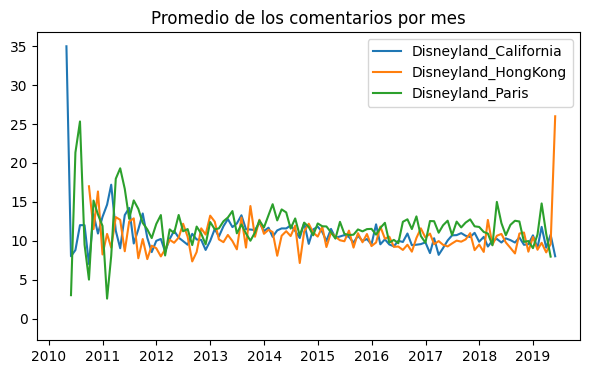

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))

for Disneyland in texto_sentimientos.Disneyland.unique():
    df = texto_sentimientos[texto_sentimientos.Disneyland == Disneyland].copy()
    df = df.set_index("fecha")
    df = df[['sentimiento']].resample('1M').mean()
    ax.plot(df.index, df.sentimiento, label=Disneyland)

ax.set_title("Promedio de los comentarios por mes")
ax.legend()

In [ ]:
    print(disneyland)


Disneyland_Paris


In [ ]:
# Contador de comentarios positivos neutros y negativos
# ==============================================================================

def perfil_sentimientos(df):
    print(disneyland)
    print("=" * 12)
    print(f"Positivos: {sum(df.sentimiento > 0)}")
    print(f"Neutros  : {sum(df.sentimiento == 0)}")
    print(f"Negativos: {sum(df.sentimiento < 0)}")
    print(" ")

for disneyland, df in texto_sentimientos.groupby("Disneyland"):
    perfil_sentimientos(df)

Disneyland_California
Positivos: 16315
Neutros  : 395
Negativos: 1195
 
Disneyland_HongKong
Positivos: 8307
Neutros  : 203
Negativos: 482
 
Disneyland_Paris
Positivos: 11088
Neutros  : 252
Negativos: 1238
 


In [ ]:
# Contador de comentarios positivos neutros y negativos
# ==============================================================================

def perfil_sentimientos(df):
    print(disneyland)
    print("=" * 12)
    print(f"Positivos: {sum(df.sentimiento > 0)}")
    print(f"Neutros  : {sum(df.sentimiento == 0)}")
    print(f"Negativos: {sum(df.sentimiento < 0)}")
    print(" ")

for disneyland, df in texto_sentimientos.groupby("Disneyland"):
    perfil_sentimientos(df)

Disneyland_California
Positivos: 16315
Neutros  : 395
Negativos: 1195
 
Disneyland_HongKong
Positivos: 8307
Neutros  : 203
Negativos: 482
 
Disneyland_Paris
Positivos: 11088
Neutros  : 252
Negativos: 1238
 


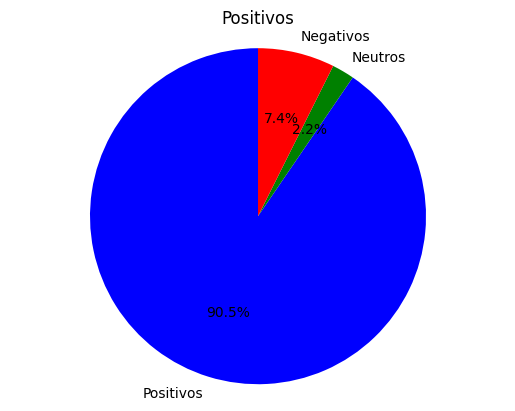

In [ ]:
import matplotlib.pyplot as plt

# Datos
labels = ['Positivos', 'Neutros', 'Negativos']
sizes = [16315+8307+11088, 395+203+252, 1195+482+1238]
colors = ['blue', 'green', 'red']

# Crear la gráfica de pastel
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Ajustar el aspecto de la gráfica
plt.axis('equal')

# Mostrar la gráfica
plt.title('Positivos')
plt.show()

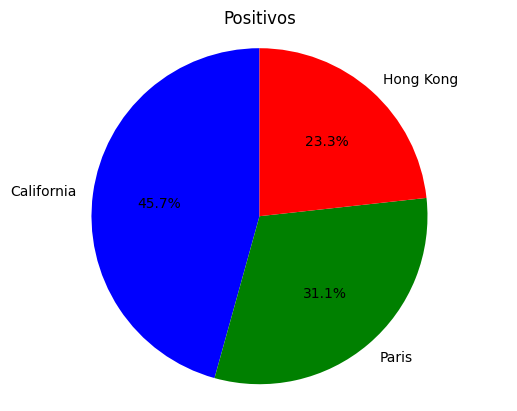

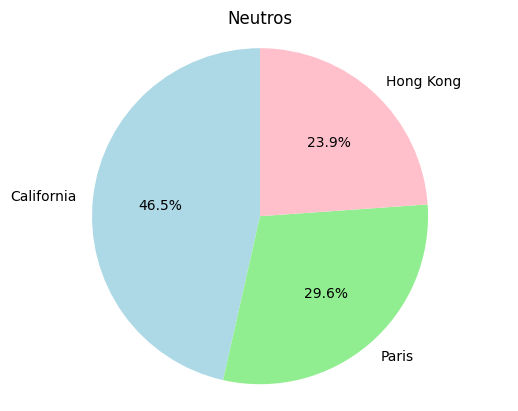

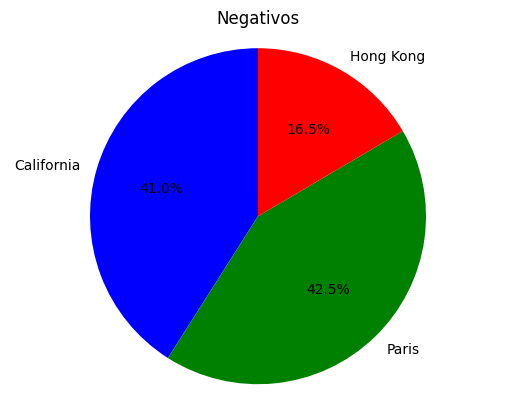

In [ ]:
import matplotlib.pyplot as plt

# Datos
labels = ['California', 'Paris', 'Hong Kong']
sizes = [16315, 11088, 8307]
colors = ['blue', 'green', 'red']

# Crear la gráfica de pastel
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Ajustar el aspecto de la gráfica
plt.axis('equal')

# Mostrar la gráfica
plt.title('Positivos')
plt.show()

import matplotlib.pyplot as plt

# Datos
labels = ['California', 'Paris', 'Hong Kong']
sizes = [395, 252, 203]
colors = ['lightblue', 'lightgreen', 'pink']

# Crear la gráfica de pastel
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Ajustar el aspecto de la gráfica
plt.axis('equal')

# Mostrar la gráfica
plt.title('Neutros')
plt.show()

# Datos
labels = ['California', 'Paris', 'Hong Kong']
sizes = [1195, 1238, 482]
colors = ['blue', 'green', 'red']

# Crear la gráfica de pastel
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Ajustar el aspecto de la gráfica
plt.axis('equal')

# Mostrar la gráfica
plt.title('Negativos')
plt.show()

## Analisis de sentimiento usando TextBlob

In [ ]:
# Lectura de datos
# ==============================================================================
import pandas as pd
dataset = pd.read_excel('/content/DisneylandReviews.xlsx')#,encoding='latin-1')


In [ ]:
# Se seleccionan y renombran las columnas de interés
#df = df[['Review_ID',	'Rating','Year_Month','Reviewer_Location','Review_Text','Branch']]
dataset.columns = ['ID', 'Rating', 'fecha', 'país_visitante','Text','Disneyland']
dataset.head()

,ID,Rating,fecha,país_visitante,Text,Disneyland
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [ ]:
import re

# Define a function to clean the text
def clean(text):
    # Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text

# Cleaning the text in the review column
dataset['Cleaned Reviews'] = dataset['Text'].apply(clean)
dataset.head()

,ID,Rating,fecha,país_visitante,Text,Disneyland,Cleaned Reviews
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,If you ve ever been to Disneyland anywhere you...
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,Its been a while since d last time we visit HK...
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,Thanks God it wasn t too hot or too humid when...
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,HK Disneyland is a great compact park Unfortun...
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,the location is not in the city took around ho...


In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')

# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

dataset['POS tagged'] = dataset['Cleaned Reviews'].apply(token_stop_pos)
dataset.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,ID,Rating,fecha,país_visitante,Text,Disneyland,Cleaned Reviews,POS tagged
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,If you ve ever been to Disneyland anywhere you...,"[(ever, r), (Disneyland, n), (anywhere, r), (f..."
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,Its been a while since d last time we visit HK...,"[(since, None), (last, a), (time, n), (visit, ..."
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,Thanks God it wasn t too hot or too humid when...,"[(Thanks, n), (God, n), (hot, a), (humid, a), ..."
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,HK Disneyland is a great compact park Unfortun...,"[(HK, n), (Disneyland, n), (great, a), (compac..."
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,the location is not in the city took around ho...,"[(location, n), (city, n), (took, v), (around,..."


In [ ]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

dataset['Lemma'] = dataset['POS tagged'].apply(lemmatize)
dataset.head()

,ID,Rating,fecha,país_visitante,Text,Disneyland,Cleaned Reviews,POS tagged,Lemma
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,If you ve ever been to Disneyland anywhere you...,"[(ever, r), (Disneyland, n), (anywhere, r), (f...",ever Disneyland anywhere find Disneyland Hon...
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,Its been a while since d last time we visit HK...,"[(since, None), (last, a), (time, n), (visit, ...",since last time visit HK Disneyland Yet time...
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,Thanks God it wasn t too hot or too humid when...,"[(Thanks, n), (God, n), (hot, a), (humid, a), ...",Thanks God hot humid visit park otherwise wo...
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,HK Disneyland is a great compact park Unfortun...,"[(HK, n), (Disneyland, n), (great, a), (compac...",HK Disneyland great compact park Unfortunate...
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,the location is not in the city took around ho...,"[(location, n), (city, n), (took, v), (around,...",location city take around hour Kowlon kid li...


In [ ]:
dataset[['Text', 'Lemma']]

,Text,Lemma
0,If you've ever been to Disneyland anywhere you...,ever Disneyland anywhere find Disneyland Hon...
1,Its been a while since d last time we visit HK...,since last time visit HK Disneyland Yet time...
2,Thanks God it wasn t too hot or too humid wh...,Thanks God hot humid visit park otherwise wo...
3,HK Disneyland is a great compact park. Unfortu...,HK Disneyland great compact park Unfortunate...
4,"the location is not in the city, took around 1...",location city take around hour Kowlon kid li...
...,...,...
42651,i went to disneyland paris in july 03 and thou...,go disneyland paris july think brilliant vis...
42652,2 adults and 1 child of 11 visited Disneyland ...,adult child visited Disneyland Paris beginni...
42653,My eleven year old daughter and myself went to...,eleven year old daughter go visit son London...
42654,"This hotel, part of the Disneyland Paris compl...",hotel part Disneyland Paris complex wonderfu...


## TextBlob

In [ ]:
from textblob import TextBlob

# function to calculate subjectivity
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity

# function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [ ]:
fin_data = pd.DataFrame(dataset[['Text', 'Lemma']])

In [ ]:
# fin_data['Subjectivity'] = fin_data['Lemma'].apply(getSubjectivity)
fin_data['Polarity'] = fin_data['Lemma'].apply(getPolarity)
fin_data['Analysis'] = fin_data['Polarity'].apply(analysis)
fin_data.head()

,Text,Lemma,Polarity,Analysis
0,If you've ever been to Disneyland anywhere you...,ever Disneyland anywhere find Disneyland Hon...,0.226852,Positive
1,Its been a while since d last time we visit HK...,since last time visit HK Disneyland Yet time...,0.167544,Positive
2,Thanks God it wasn t too hot or too humid wh...,Thanks God hot humid visit park otherwise wo...,0.168074,Positive
3,HK Disneyland is a great compact park. Unfortu...,HK Disneyland great compact park Unfortunate...,0.262500,Positive
4,"the location is not in the city, took around 1...",location city take around hour Kowlon kid li...,0.266667,Positive


In [ ]:
tb_counts = fin_data.Analysis.value_counts()
tb_counts

Positive    38826
Negative     3447
Neutral       383
Name: Analysis, dtype: int64

([<matplotlib.patches.Wedge at 0x7fcc5cbf63e0>,
 [Text(-1.0565271380035035, 0.30618688192364807, 'Positive'),
  Text(1.0474711322625796, -0.3358634053846139, 'Negative'),
  Text(1.3494629517679686, -0.03807547512089213, 'Neutral')],
 [Text(-0.5762875298200928, 0.167011026503808, '91.0%'),
  Text(0.5713478903250434, -0.1831982211188803, '8.1%'),
  Text(0.8496618585205727, -0.023973447298339487, '0.9%')])

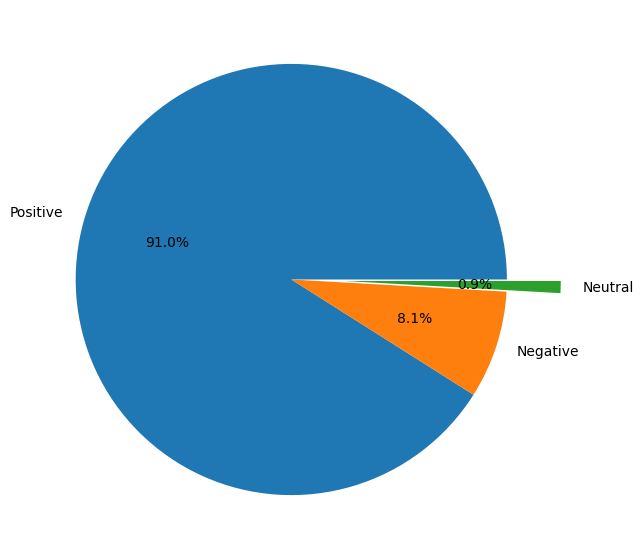

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

tb_count= fin_data.Analysis.value_counts()
plt.figure(figsize=(10, 7))
plt.pie(tb_counts.values, labels = tb_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)


# VADER

In [ ]:
!pip install vaderSentiment


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# function to calculate vader sentiment
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

fin_data['Vader Sentiment'] = fin_data['Lemma'].apply(vadersentimentanalysis)

In [ ]:
# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'

fin_data['Vader Analysis'] = fin_data['Vader Sentiment'].apply(vader_analysis)
fin_data.head()

,Text,Lemma,Polarity,Analysis,Vader Sentiment,Vader Analysis
0,If you've ever been to Disneyland anywhere you...,ever Disneyland anywhere find Disneyland Hon...,0.226852,Positive,0.7889,Positive
1,Its been a while since d last time we visit HK...,since last time visit HK Disneyland Yet time...,0.167544,Positive,0.9863,Positive
2,Thanks God it wasn t too hot or too humid wh...,Thanks God hot humid visit park otherwise wo...,0.168074,Positive,0.9853,Positive
3,HK Disneyland is a great compact park. Unfortu...,HK Disneyland great compact park Unfortunate...,0.262500,Positive,0.8316,Positive
4,"the location is not in the city, took around 1...",location city take around hour Kowlon kid li...,0.266667,Positive,0.5106,Positive


In [ ]:
vader_counts = fin_data['Vader Analysis'].value_counts()
vader_counts

Positive    36155
Neutral      5209
Negative     1292
Name: Vader Analysis, dtype: int64

([<matplotlib.patches.Wedge at 0x7fcc5ce2f880>,
 [Text(-1.0650607280852227, 0.5528522817991941, 'Positive'),
  Text(0.9237389728053431, -0.5972489515441026, 'Neutral'),
  Text(1.0950238002852508, -0.1045125677076563, 'Negative')],
 [Text(-0.6212854247163798, 0.3224971643828632, '84.8%'),
  Text(0.5038576215301871, -0.3257721553876923, '12.2%'),
  Text(0.5972857092465004, -0.057006855113267065, '3.0%')])

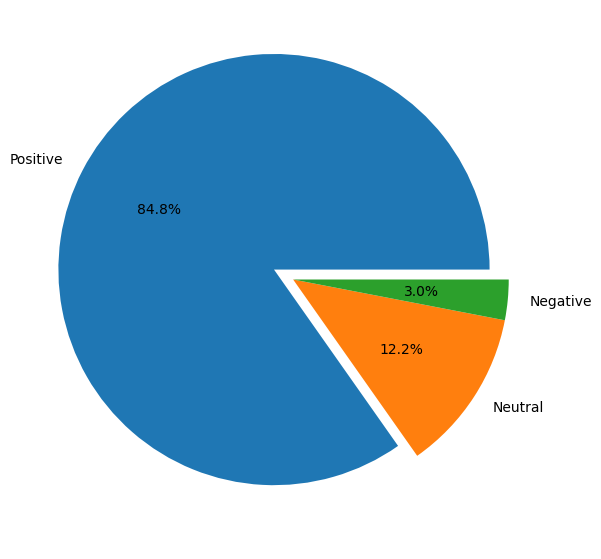

In [ ]:
vader_counts= fin_data['Vader Analysis'].value_counts()
plt.figure(figsize=(10, 7))
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0.1, 0, 0), autopct='%1.1f%%', shadow=False)
# plt.legend()

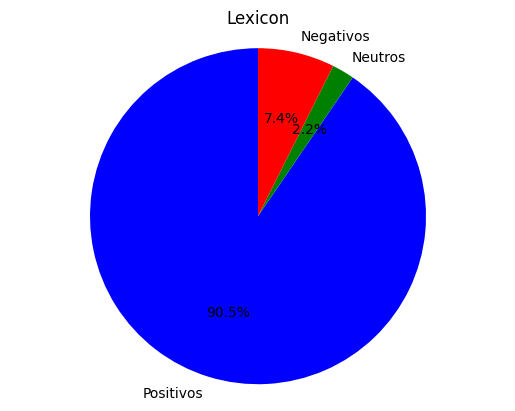

Text(0.5, 1.0, 'Vader')

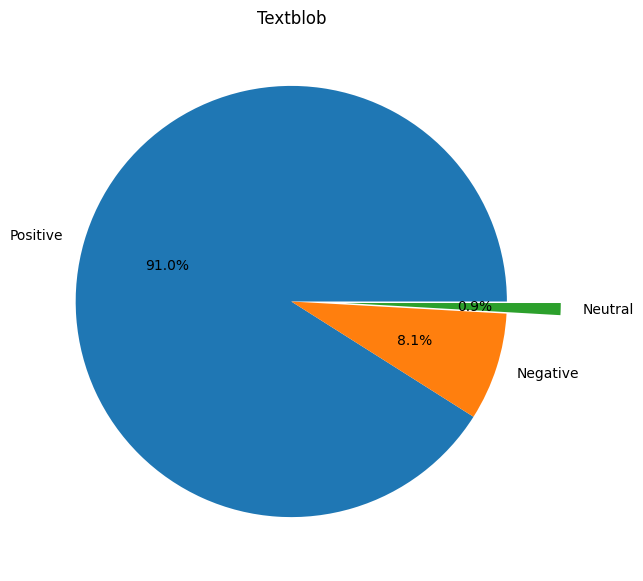

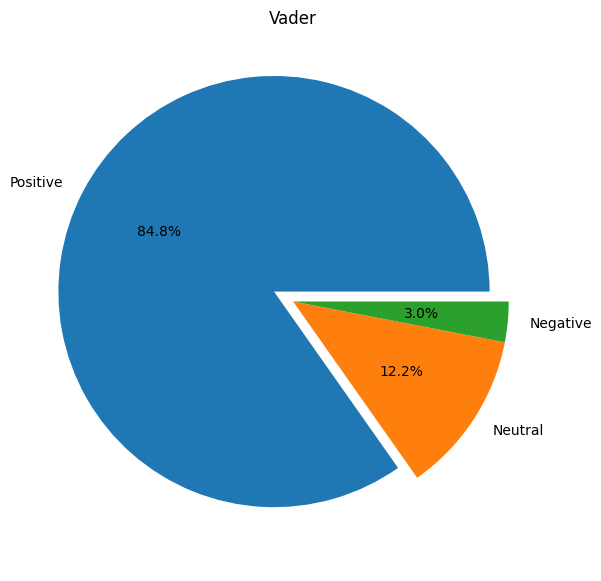

In [ ]:
import matplotlib.pyplot as plt

# Datos
labels = ['Positivos', 'Neutros', 'Negativos']
sizes = [16315+8307+11088, 395+203+252, 1195+482+1238]
colors = ['blue', 'green', 'red']

# Crear la gráfica de pastel
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Ajustar el aspecto de la gráfica
plt.axis('equal')

# Mostrar la gráfica
plt.title('Lexicon')
plt.show()

%matplotlib inline

tb_count= fin_data.Analysis.value_counts()
plt.figure(figsize=(10, 7))
plt.pie(tb_counts.values, labels = tb_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.title('Textblob')

vader_counts= fin_data['Vader Analysis'].value_counts()
plt.figure(figsize=(10, 7))
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0.1, 0, 0), autopct='%1.1f%%', shadow=False)
plt.title('Vader')


In [ ]:
pip install aspose-pdf


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 MB 2.3 MB/s eta 0:00:00


RuntimeError: ignored